# DNN: analysis with Keras of 2D data

In [116]:
import numpy        as np
import pandas       as pd
import os #to save the initial weights

'''
# Original
from  keras.models import Sequential # basic NN
from  keras.layers import Dense, Dropout
'''
#Ema's Laptop
import tensorflow.keras
from   tensorflow.keras.models                import Sequential 
from   tensorflow.keras.layers                import Dense, Dropout
from   tensorflow.keras.optimizers            import SGD 
from   sklearn.model_selection                import GridSearchCV
from   tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from   tensorflow.keras.callbacks             import ModelCheckpoint
from   tensorflow.keras.optimizers            import SGD 
from   tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from   sklearn.model_selection                import GridSearchCV


#dense : normal layer(?)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

%run nonlinear_function.py

# training data
perc_train = 0.8

## 1.0) Load data

In [154]:
# Keras works with numpy arrays: just use them from the start
TYPE  = 1

x_125  = np.loadtxt( filename( 'data_125',   TYPE), delimiter = ' ' )
y_125  = np.loadtxt( filename( 'labels_125', TYPE), delimiter = ' ' )

x_250  = np.loadtxt( filename( 'data_125',   TYPE), delimiter = ' ' )
y_250  = np.loadtxt( filename( 'labels_125', TYPE), delimiter = ' ' )

x_500  = np.loadtxt( filename( 'data_500',   TYPE), delimiter = ' ' )
y_500  = np.loadtxt( filename( 'labels_500', TYPE), delimiter = ' ' )

x_1K   = np.loadtxt( filename( 'data_1K',  TYPE), delimiter   = ' ' )
y_1K   = np.loadtxt( filename( 'labels_1K',TYPE), delimiter   = ' ' )

x_2K   = np.loadtxt( filename( 'data_2K',   TYPE), delimiter  = ' ' )
y_2K   = np.loadtxt( filename( 'labels_2K', TYPE), delimiter  = ' ' )

x_4K   = np.loadtxt( filename( 'data_4K',   TYPE), delimiter  = ' ' )
y_4K   = np.loadtxt( filename( 'labels_4K', TYPE), delimiter  = ' ' )

x_8K   = np.loadtxt( filename( 'data_8K',  TYPE), delimiter   = ' ' )
y_8K   = np.loadtxt( filename( 'labels_8K',TYPE), delimiter   = ' ' )

x_16K  = np.loadtxt( filename( 'data_16K',  TYPE), delimiter  = ' ' )
y_16K  = np.loadtxt( filename( 'labels_16K',TYPE), delimiter  = ' ' )

#Fare una dict
N_125, N_250, N_500, N_1K  = len( x_125 ), len( x_250 ), len( x_500 ), len( x_1K  )
N_2K,  N_4K,  N_8K,  N_16K = len( x_1K ),  len( x_4K  ), len( x_8K  ), len( x_16K )


# dim of a sample
L = len( x_4K[0] ) # L = 2

N_train_125, N_train_250 = int(perc_train * N_125), int(perc_train * N_250)
N_train_500, N_train_1K  = int(perc_train * N_500), int(perc_train * N_1K)
N_train_2K,  N_train_4K  = int(perc_train * N_2K),  int(perc_train * N_4K)
N_train_8K,  N_train_16K = int(perc_train * N_8K),  int(perc_train * N_16K)

print(f'Data: {N_125, N_250, N_500, N_1K, N_2K, N_4K, N_8K, N_16K}',
      f'\nTrain: {N_train_125, N_train_250, N_train_500, N_train_1K, N_train_2K, N_train_4K, N_train_8K, N_train_16K}')

Data: (125, 125, 500, 1000, 1000, 4000, 8000, 16000) 
Train: (100, 100, 400, 800, 800, 3200, 6400, 12800)


## 1.1)  Data augmentation 

In [158]:
def agument_data( org_x_train, org_y_train, multiplier = 2, epsilon = 1e-4):
    
    org_N = org_x_train.shape[0]
    org_L = org_x_train.shape[1]
    
    x_train_agumented = np.zeros((org_N*multiplier,org_L))
    y_train_agumented = np.zeros((org_N*multiplier))

    x_train_agumented[:org_N] = np.copy(org_x_train)
    y_train_agumented[:org_N] = np.copy(org_y_train)
    
    # Filling the rest of the array
    for i in range (multiplier - 1):
        x_train_agumented[i*org_N:(i+1)*org_N] = np.copy(org_x_train)+ np.random.uniform(-epsilon,epsilon,size=(org_N,org_L))
        y_train_agumented[i*org_N:(i+1)*org_N] = np.copy(org_y_train)

    # Shuffeling the data
    permutation = np.random.permutation(x_train_agumented.shape[0])

    x_train_agumented = x_train_agumented[permutation]
    y_train_agumented = y_train_agumented[permutation]

    return x_train_agumented, y_train_agumented

In [95]:
# DATA AUGMENTATION: for each data (x1, x2) are generated 10 points (x +ai, y + bi) for i = 1, .. , 10.
'''
std   = 1
noise = np.random.normal( loc   = 0, scale = std, size = (N_train_4K*10, 2)) 
x_train_noise = np.zeros( shape = ( N_train_4K*10, 2 ))
y_train_noise = np.zeros( shape = ( N_train_4K*10, 1 ))
for j in range ( N_train_4K ):
    x_train_noise[j*10] = x_4K[j] + noise[j*10]
    y_train_noise[j*10] = y_4K[j]
    #mean = x_train_noise[j*10]
    #cov  = [[0.1, 0], [0, 0.1]] 
    #print(x_train_noise[j*10], y_train_noise[j*10])
    for i in range (9):
        x_train_noise[(j*10)+i+1] = x_4K[j] + noise[(j*10)+i+1]
        y_train_noise[(j*10)+i+1] = y_4K[j]
        #print(x_train_noise[(j*10)+i+1], y_train_noise[(j*10)+i+1])
'''

## 1.1) Split training and test data

Train 4K: 3200 		 Validation 4K: 800
Train 1K: 800 		 Validation 1K: 200
Train 16K: 12800 	 Validation 16K: 3200
Train noise: 32000 	 Validation noise: 800


Text(0.5, 1.0, 'data augmented')

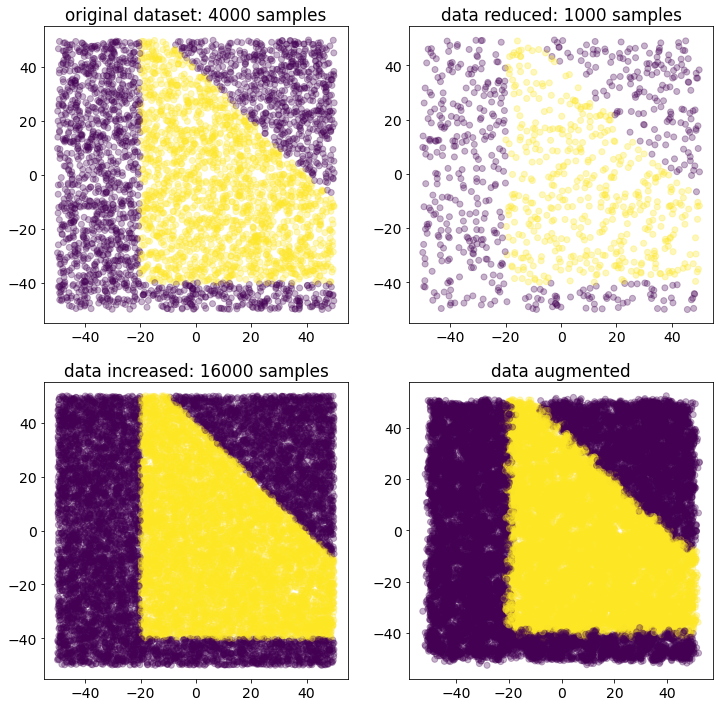

In [96]:
x_train_125,  y_train_4K  = x_4K[0:N_train_4K],   y_4K[0:N_train_4K]
x_valid_125,  y_valid_4K  = x_4K[N_train_4K:],    y_4K[N_train_4K:]
x_train_1,  y_train_1K  = x_1K[0:N_train_1K],   y_1K[0:N_train_1K]
x_valid_1K,  y_valid_1K  = x_1K[N_train_1K:],    y_1K[N_train_1K:]
x_train_16K, y_train_16K = x_16K[0:N_train_16K], y_16K[0:N_train_16K]
x_valid_16K, y_valid_16K = x_16K[N_train_16K:],  y_16K[N_train_16K:]
x_train_4K,  y_train_4K  = x_4K[0:N_train_4K],   y_4K[0:N_train_4K]
x_valid_4K,  y_valid_4K  = x_4K[N_train_4K:],    y_4K[N_train_4K:]
x_train_1K,  y_train_1K  = x_1K[0:N_train_1K],   y_1K[0:N_train_1K]
x_valid_1K,  y_valid_1K  = x_1K[N_train_1K:],    y_1K[N_train_1K:]
x_train_16K, y_train_16K = x_16K[0:N_train_16K], y_16K[0:N_train_16K]
x_valid_16K, y_valid_16K = x_16K[N_train_16K:],  y_16K[N_train_16K:]

x_noise       = np.concatenate([x_train_noise, x_valid_4K])
y_valid_noise = y_valid_4K.reshape(len(y_valid_4K), 1)
y_noise       = np.concatenate([y_train_noise, y_valid_noise])

print( "Train 4K:",    len(x_train_4K), "\t\t Validation 4K:",     len(x_valid_4K) )
print( "Train 1K:",    len(x_train_1K), "\t\t Validation 1K:",     len(x_valid_1K) )
print( "Train 16K:",   len(x_train_16K), "\t Validation 16K:",     len(x_valid_16K))
print( "Train noise:", len(x_train_noise), "\t Validation noise:", len(x_valid_4K) ) #I DON'T KNOW WHAT TO USE AS DIMENSION FOR THIS THE VALIDATION SET

fig, AX = plt.subplots (2, 2, figsize = (12, 12.))
ax = AX[0][0]
ax.scatter(x_4K[:,0], x_4K[:,1], c = y_4K, alpha = 0.3 )
ax.set_title("original dataset: 4000 samples")
ax = AX[0][1] 
ax.scatter(x_1K[:,0], x_1K[:,1], c = y_1K, alpha = 0.3 )
ax.set_title("data reduced: 1000 samples")
ax = AX[1][0]
ax.scatter(x_16K[:,0], x_16K[:,1], c = y_16K, alpha = 0.3 )
ax.set_title("data increased: 16000 samples")
ax = AX[1][1]
ax.scatter(x_noise[:,0], x_noise[:,1], c = y_noise, alpha = 0.3 )
ax.set_title("data augmented")

## Rescale input data

In [97]:
def Rescale( x ):
    # I cal also take away the mean
    #return (x-x.mean())/np.sqrt(x.var())
    return x / 50

x_train_4K    = Rescale( x_train_4K )
x_valid_4K    = Rescale( x_valid_4K )

x_train_1K    = Rescale( x_train_1K )
x_valid_1K    = Rescale( x_valid_1K )

x_train_16K   = Rescale( x_train_16K )
x_valid_16K   = Rescale( x_valid_16K )

x_train_noise = Rescale( x_train_noise )
x_valid_noise = Rescale( x_valid_4K )

## 1.3) Define the model with Keras

In [102]:
# reproducibility
np.random.seed(12345)

def create_model(CASE = 1, optimizer = "adam", dropout = 0.2, hidden_layers = 2,
                 activation_hidden_layers = 'relu', number_of_nodes = 20):
    
    if CASE == 1 :
        model = Sequential()
        model.add(Dense(L,input_shape=(L,),activation = 'relu'))
        for i in range(hidden_layers):
            model.add(Dense(number_of_nodes, activation=activation_hidden_layers))
        model.add(Dropout(dropout))
        model.add(Dense(1,activation='sigmoid'))

    if CASE == 2 :
        model = Sequential()
        model.add(Dense(L, input_shape = (L,),activation = 'sigmoid'))
        model.add(Dense(3, activation = 'sigmoid'))
        model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss= 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    
    model.save_weights('initial_weights.txt')
    
    return model


In [103]:
model  = create_model(CASE = 1, optimizer = "adam",dropout = 0.2,hidden_layers = 2,
                      activation_hidden_layers = 'relu', number_of_nodes = 20)

model.summary()

Model: "sequential_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_600 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_601 (Dense)            (None, 20)                60        
_________________________________________________________________
dense_602 (Dense)            (None, 20)                420       
_________________________________________________________________
dropout_150 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_603 (Dense)            (None, 1)                 21        
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________


## 1.4) Training process

### 1.4.0)  Define the grid for the predictions

In [104]:

dX = 2                        
X1 = np.arange(-50,50+dX, dX) # from - 50 to 50 with only even number
LG = len(X1)                  # 51
grid = np.zeros((LG*LG,2))    # 2601, 
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

#print(grid)

# RESCALE
grid_r = Rescale(grid)



51 2601
[50. 50.]


In [131]:
#checkpoint_path = "Checkpoint/cp.ckpt"
#checkpoint_dir  = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath="cp.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)


[ 5.4419262e-04  2.9110702e-02 -2.5314320e-04  0.0000000e+00
  3.4337968e-04  1.0591213e-03  8.4394038e-02  1.0508480e-03
  0.0000000e+00 -7.3861645e-04 -1.9305105e-04  1.7525649e-04
  1.9677753e-05  0.0000000e+00 -5.7777679e-03 -1.0666688e-03
  1.5368077e-04 -9.2580909e-04 -2.5729026e-04  0.0000000e+00]


(array([[0., 1., 0., 1.],
        [0., 0., 2., 0.],
        [0., 1., 0., 1.],
        [1., 1., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 0., 2., 0.],
        [0., 0., 1., 1.],
        [1., 0., 1., 0.],
        [2., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [1., 0., 0., 1.],
        [0., 0., 1., 1.],
        [1., 1., 0., 0.]]),
 array([-0.5115475 , -0.25995323, -0.00835894,  0.24323535,  0.49482962],
       dtype=float32),
 <a list of 20 BarContainer objects>)

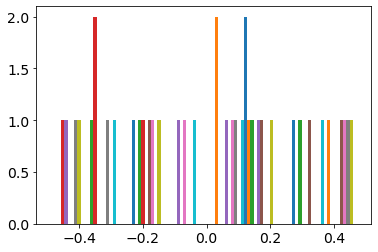

In [132]:
initial_weights = model.get_weights()
model.save_weights('initial_weights.txt')
#pd.DataFrame(df_1k)
print(initial_weights[3] )
plt.hist(initial_weights[2], bins = 4)

### 1.4.1)  Fit over each dataset and compute che corresponding prediction

In [133]:
mcp_save_1K = ModelCheckpoint('.mdl_wts_fit_1K.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#Loading standard weights 
model.load_weights('initial_weights.txt')
                                  
nepoch = 400

fit_1K  = model.fit(x_train_1K, y_train_1K,
                      epochs = nepoch, batch_size = 50,
                      validation_data = (x_valid_1K, y_valid_1K), 
                      callbacks=[cp_callback], verbose = False)

pred_1K = model.predict(grid_r)


Epoch 00001: saving model to cp.ckpt

Epoch 00002: saving model to cp.ckpt

Epoch 00003: saving model to cp.ckpt

Epoch 00004: saving model to cp.ckpt

Epoch 00005: saving model to cp.ckpt

Epoch 00006: saving model to cp.ckpt

Epoch 00007: saving model to cp.ckpt

Epoch 00008: saving model to cp.ckpt

Epoch 00009: saving model to cp.ckpt

Epoch 00010: saving model to cp.ckpt

Epoch 00011: saving model to cp.ckpt

Epoch 00012: saving model to cp.ckpt

Epoch 00013: saving model to cp.ckpt

Epoch 00014: saving model to cp.ckpt

Epoch 00015: saving model to cp.ckpt

Epoch 00016: saving model to cp.ckpt

Epoch 00017: saving model to cp.ckpt

Epoch 00018: saving model to cp.ckpt

Epoch 00019: saving model to cp.ckpt

Epoch 00020: saving model to cp.ckpt

Epoch 00021: saving model to cp.ckpt

Epoch 00022: saving model to cp.ckpt

Epoch 00023: saving model to cp.ckpt

Epoch 00024: saving model to cp.ckpt

Epoch 00025: saving model to cp.ckpt

Epoch 00026: saving model to cp.ckpt

Epoch 00027


Epoch 00218: saving model to cp.ckpt

Epoch 00219: saving model to cp.ckpt

Epoch 00220: saving model to cp.ckpt

Epoch 00221: saving model to cp.ckpt

Epoch 00222: saving model to cp.ckpt

Epoch 00223: saving model to cp.ckpt

Epoch 00224: saving model to cp.ckpt

Epoch 00225: saving model to cp.ckpt

Epoch 00226: saving model to cp.ckpt

Epoch 00227: saving model to cp.ckpt

Epoch 00228: saving model to cp.ckpt

Epoch 00229: saving model to cp.ckpt

Epoch 00230: saving model to cp.ckpt

Epoch 00231: saving model to cp.ckpt

Epoch 00232: saving model to cp.ckpt

Epoch 00233: saving model to cp.ckpt

Epoch 00234: saving model to cp.ckpt

Epoch 00235: saving model to cp.ckpt

Epoch 00236: saving model to cp.ckpt

Epoch 00237: saving model to cp.ckpt

Epoch 00238: saving model to cp.ckpt

Epoch 00239: saving model to cp.ckpt

Epoch 00240: saving model to cp.ckpt

Epoch 00241: saving model to cp.ckpt

Epoch 00242: saving model to cp.ckpt

Epoch 00243: saving model to cp.ckpt

Epoch 00244

In [141]:
os.listdir(cp.ckpt)

NameError: name 'cp' is not defined

In [134]:
print(model.get_weights())

[array([[ 0.70928997,  0.22583552],
       [ 0.29628474, -0.86762977]], dtype=float32), array([0.58306384, 0.5650935 ], dtype=float32), array([[ 0.8791003 ,  0.41077518, -0.3384737 , -0.20554477, -0.7411931 ,
        -0.05083439, -0.7865508 ,  0.23045649, -0.08014151,  0.48557058,
         0.7197293 ,  0.5317075 , -0.34544855, -0.5115475 , -0.3219217 ,
         0.53707683,  0.96272326, -0.5497624 ,  0.09797321, -0.1716635 ],
       [ 0.21075577,  0.64534765,  0.4392395 , -0.34065425,  0.20275927,
         0.6497892 ,  0.11773391, -0.60207784, -0.3142891 ,  0.19608665,
         0.42401814,  0.13712637,  0.39071772, -0.2803172 ,  0.67874086,
         0.06087869,  0.0515378 ,  0.60921425,  0.531229  , -0.41412038]],
      dtype=float32), array([-0.12162767, -0.16212864, -0.23745598,  0.        ,  0.46941862,
        0.09423979,  1.1508652 ,  0.32580063,  0.        , -0.3400294 ,
       -0.21372165, -0.12060045, -0.16499448,  0.        , -0.47871312,
       -0.18034755, -0.05315182, -0.249

In [107]:
#mcp_save_4K = ModelCheckpoint('.mdl_wts_fit_4K.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Loading standard weights 
model.load_weights('initial_weights.txt')

fit_4K  = model.fit(x_train_4K, y_train_4K,
                      epochs = nepoch, batch_size = 50,
                      validation_data = (x_valid_4K, y_valid_4K), 
                      verbose = False)

pred_4K = model.predict(grid_r)
print(model.get_weights())

[array([[ 1.2546176 ,  0.32010198],
       [ 0.12546538, -0.8721154 ]], dtype=float32), array([0.64658475, 0.868517  ], dtype=float32), array([[ 1.213537  ,  0.3742624 , -0.12889126, -0.20554477, -1.7163233 ,
        -0.24363375,  0.34395176,  0.91444653, -0.08014151,  0.6609474 ,
         0.68008465,  0.8388179 , -0.5148559 , -0.5115475 , -0.45026052,
         0.6399888 ,  0.7639359 , -0.38297427,  0.28487912, -0.1716635 ],
       [ 0.10388723,  0.52787846,  0.57387733, -0.34065425, -0.3160758 ,
         0.79184026,  0.2360324 , -1.1225798 , -0.3142891 ,  0.13147126,
         0.24908672,  0.07525965,  0.4219619 , -0.2803172 ,  0.39458603,
         0.11706147,  0.05869511,  0.7713293 ,  0.31733668, -0.41412038]],
      dtype=float32), array([-0.12591146, -0.02030849, -0.75730604,  0.        ,  0.6464766 ,
        0.7221842 , -0.07043453, -0.1339211 ,  0.        , -0.13467942,
       -0.04629608, -0.06279103,  0.14514284,  0.        ,  0.13144708,
       -0.13692372, -0.08069316, -0.751

In [109]:
model.load_weights('initial_weights.txt')

fit_16K   = model.fit(x_train_16K, y_train_16K,
                      epochs = nepoch, batch_size = 50,
                      validation_data = (x_valid_16K, y_valid_16K), 
                      verbose = False)

pred_16K = model.predict(grid_r)
print(model.get_weights())

[array([[ 1.1528431 ,  0.10587036],
       [ 0.14830866, -1.0062064 ]], dtype=float32), array([0.64621776, 0.9818777 ], dtype=float32), array([[ 1.3542447 ,  0.80907786, -0.21021412, -0.20554477, -0.30219996,
        -0.29153252, -0.35347107,  0.4726487 , -0.08014151,  0.7649711 ,
         1.295354  ,  1.2395195 , -0.29223835, -0.5115475 , -0.25428066,
         1.0172509 ,  1.2307662 , -0.5093894 ,  0.83069557, -0.1716635 ],
       [ 0.16470362,  0.2478693 ,  0.5672744 , -0.34065425,  0.5978198 ,
         0.97751856,  0.6291094 , -0.9910058 , -0.3142891 ,  0.24005416,
         0.24219641,  0.12965623,  0.6390951 , -0.2803172 ,  0.51663846,
         0.12754439,  0.1135341 ,  0.77986854,  0.18388036, -0.41412038]],
      dtype=float32), array([-0.21587451, -0.5679954 , -0.70844066,  0.        , -0.41882774,
        0.6995381 ,  1.0308992 ,  0.5750261 ,  0.        , -0.51616293,
       -0.23997752, -0.28884903, -0.5518046 ,  0.        , -0.35362476,
       -0.24729472, -0.26340863, -0.522

In [110]:
model.load_weights('initial_weights.txt')

fit_noise = model.fit(x_train_noise, y_train_noise,
                      epochs = nepoch, batch_size = 50,
                      validation_data = (x_valid_4K, y_valid_4K), 
                      verbose = False)

pred_noise = model.predict(grid_r)
print(model.get_weights())

[array([[ 1.0945615 ,  0.05328549],
       [ 0.11299464, -0.93234324]], dtype=float32), array([0.6542265, 0.8871495], dtype=float32), array([[ 0.62199867,  0.16114603, -0.08327384, -0.20554477, -2.2237995 ,
        -0.53529185,  0.0323648 ,  0.8396031 , -0.08014151,  1.0121217 ,
         0.41773197,  0.5671532 , -0.14289916, -0.5115475 , -0.38512048,
         0.6227233 ,  0.35735548, -0.3314769 ,  0.49559218, -0.1716635 ],
       [ 0.07153706, -0.00321686,  0.6857751 , -0.34065425, -0.23495884,
         0.66950357,  0.04078979, -1.1558223 , -0.3142891 ,  0.18269502,
        -0.12176795,  0.07692683,  0.6575781 , -0.2803172 ,  0.29816476,
         0.05758986,  0.02694824,  0.8591598 ,  0.02887503, -0.41412038]],
      dtype=float32), array([-0.07326553, -0.21454036, -0.95826346,  0.        ,  0.91887826,
        0.4870777 , -0.13310744, -0.01320288,  0.        , -0.11816403,
       -0.35063386, -0.09294461, -0.79884833,  0.        , -0.03791256,
       -0.06533982, -0.1800516 , -0.80366

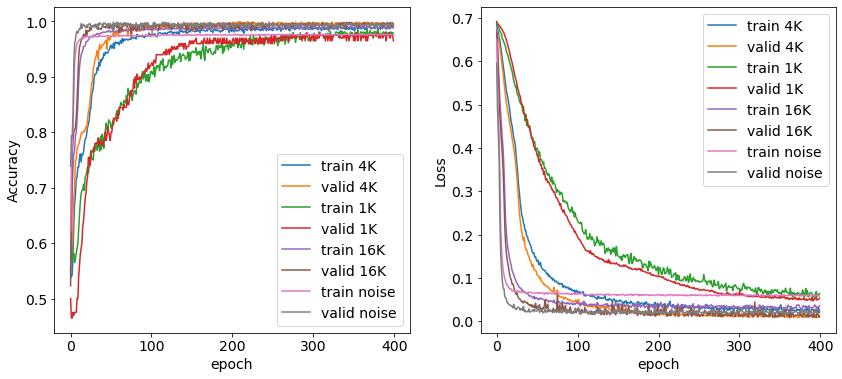

In [111]:
fig, AX = plt.subplots (1, 2, figsize = (14, 6.))
ax = AX[0]
ax.plot(fit_4K.history['accuracy'], label = 'train 4K')
ax.plot(fit_4K.history['val_accuracy'], label = 'valid 4K')
ax.plot(fit_1K.history['accuracy'], label = 'train 1K')
ax.plot(fit_1K.history['val_accuracy'], label = 'valid 1K')
ax.plot(fit_16K.history['accuracy'], label = 'train 16K')
ax.plot(fit_16K.history['val_accuracy'],   label = 'valid 16K')
ax.plot(fit_noise.history['accuracy'],     label = 'train noise')
ax.plot(fit_noise.history['val_accuracy'], label = 'valid noise')
ax.set_xlabel('epoch')
ax.set_ylabel('Accuracy')
ax.legend()

ax = AX[1]
ax.plot(fit_4K.history['loss'], label = 'train 4K')
ax.plot(fit_4K.history['val_loss'], label = 'valid 4K')
ax.plot(fit_1K.history['loss'], label = 'train 1K')
ax.plot(fit_1K.history['val_loss'], label = 'valid 1K')
ax.plot(fit_16K.history['loss'], label = 'train 16K')
ax.plot(fit_16K.history['val_loss'], label = 'valid 16K')
ax.plot(fit_noise.history['loss'], label = 'train noise')
ax.plot(fit_noise.history['val_loss'], label = 'valid noise')
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
ax.legend()

# REDUCE THE NUMBER OF EPOCHS 


<function matplotlib.pyplot.show(close=None, block=None)>

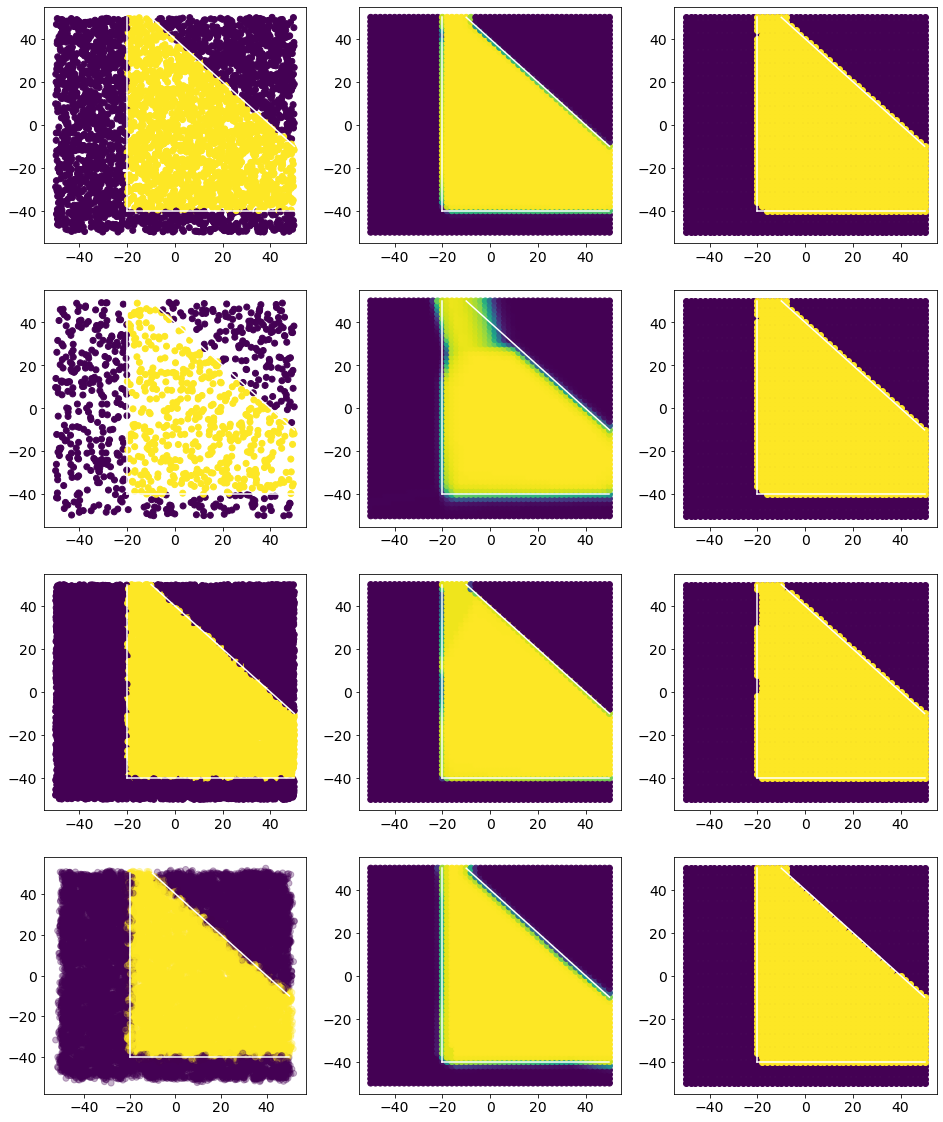

In [112]:
def boundaries():    
    ax.plot((-20,-20),(-40,50),c="w")
    ax.plot((-20,50),(-40,-40),c="w")
    ax.plot((-10,50),(50,-10),c="w")
fig,AX=plt.subplots(4,3,figsize=(16,20.))

ax=AX[0][0]
ax.scatter(x_4K[:,0],x_4K[:,1],c=y_4K)
boundaries()
ax=AX[0][1]
ax.scatter(grid[:,0],grid[:,1],c=pred_4K)
boundaries()
ax=AX[0][2]
W1=np.where(pred_4K>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()

ax=AX[1][0]
ax.scatter(x_1K[:,0],x_1K[:,1],c=y_1K)
boundaries()
ax=AX[1][1]
ax.scatter(grid[:,0],grid[:,1],c=pred_1K)
boundaries()
ax=AX[1][2]
W1=np.where(pred_4K>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()

ax=AX[2][0]
ax.scatter(x_16K[:,0],x_16K[:,1],c=y_16K)
boundaries()
ax=AX[2][1]
ax.scatter(grid[:,0],grid[:,1],c=pred_16K)
boundaries()
ax=AX[2][2]
W1=np.where(pred_16K>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()

ax=AX[3][0]
ax.scatter(x_noise[:,0], x_noise[:,1], c = y_noise, alpha = 0.3 )
boundaries()
ax=AX[3][1]
ax.scatter(grid[:,0],grid[:,1],c = pred_noise)
boundaries()
ax=AX[3][2]
W1=np.where(pred_noise>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],   c = "#440154")
ax.scatter(grid[W1,0],grid[W1,1], c = "#fde725")
boundaries()
plt.show


# Grid Search Validation

In [136]:
model_gridsearch = KerasClassifier(build_fn = create_model)

# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer  = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
dropout    = [0., 0.1, 0.2, 0.3,  0.5]
              
# define parameter dictionary
params = dict(optimizer=optimizer, activation_hidden_layers = activation, dropout= dropout)
# # call scikit grid search module
grid        = GridSearchCV(estimator=model_gridsearch, param_grid=params, n_jobs=1, cv=4)

grid_result = grid.fit(x_train_1K, y_train_1K, epochs = 2, batch_size = 100, shuffle = True, )

Epoch 1/2
600/600 [==============================] - 1s 1ms/step - loss: 0.6937 - accuracy: 0.5020
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6949 - accuracy: 0.5200
Epoch 1/2
600/600 [==============================] - 1s 1ms/step - loss: 0.6939 - accuracy: 0.4818
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6915 - accuracy: 0.5350
Epoch 1/2
600/600 [==============================] - 1s 980us/step - loss: 0.6947 - accuracy: 0.4904
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6827 - accuracy: 0.5800
Epoch 1/2
600/600 [==============================] - 1s 1ms/step - loss: 0.6944 - accuracy: 0.4933
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6851 - accuracy: 0.5650
Epoch 1/2
600/600 [==============================] - 1s 1ms/step - loss: 0.6925 - accuracy: 0.4988
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5200
Epoch 1/2
600/600 [=========

7/7 [==============================] - 0s 2ms/step - loss: 0.7031 - accuracy: 0.5350
Epoch 1/2
600/600 [==============================] - 1s 850us/step - loss: 0.7159 - accuracy: 0.5505
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6892 - accuracy: 0.5900
Epoch 1/2
600/600 [==============================] - 1s 816us/step - loss: 0.7038 - accuracy: 0.5312
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6724 - accuracy: 0.5400
Epoch 1/2
600/600 [==============================] - 1s 893us/step - loss: 0.7117 - accuracy: 0.5182
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.5792 - accuracy: 0.6500
Epoch 1/2
600/600 [==============================] - 1s 930us/step - loss: 0.7264 - accuracy: 0.4966
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 0.6566 - accuracy: 0.7100
Epoch 1/2
600/600 [==============================] - 1s 951us/step - loss: 0.8333 - accuracy: 0.5148
Epoch 2/2
7/7 [===============

7/7 [==============================] - 0s 1ms/step - loss: 0.5584 - accuracy: 0.6800
Epoch 1/2
600/600 [==============================] - 1s 840us/step - loss: 0.6780 - accuracy: 0.5954
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 0.5366 - accuracy: 0.7950
Epoch 1/2
600/600 [==============================] - 1s 874us/step - loss: 0.6899 - accuracy: 0.5015
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 0.5909 - accuracy: 0.6950
Epoch 1/2
600/600 [==============================] - 1s 902us/step - loss: 0.7031 - accuracy: 0.5691
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.5588 - accuracy: 0.7800
Epoch 1/2
600/600 [==============================] - 2s 935us/step - loss: 0.6632 - accuracy: 0.5462
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.5705 - accuracy: 0.6600
Epoch 1/2
600/600 [==============================] - 1s 887us/step - loss: 0.6524 - accuracy: 0.6027
Epoch 2/2
7/7 [===============

Epoch 1/2
600/600 [==============================] - 1s 1ms/step - loss: 0.6736 - accuracy: 0.5791
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6258 - accuracy: 0.6700
Epoch 1/2
600/600 [==============================] - 1s 951us/step - loss: 0.6872 - accuracy: 0.5406
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6232 - accuracy: 0.7250
Epoch 1/2
600/600 [==============================] - 1s 1ms/step - loss: 0.6676 - accuracy: 0.5619
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 0.5725 - accuracy: 0.6800
Epoch 1/2
600/600 [==============================] - 1s 945us/step - loss: 0.6821 - accuracy: 0.6095
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6033 - accuracy: 0.7250
Epoch 1/2
600/600 [==============================] - 1s 896us/step - loss: 0.7142 - accuracy: 0.4071
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6997 - accuracy: 0.2700
Epoch 1/2
600/600 [=====

600/600 [==============================] - 1s 1ms/step - loss: 0.6939 - accuracy: 0.6104
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6507 - accuracy: 0.6400
Epoch 1/2
600/600 [==============================] - 1s 930us/step - loss: 0.6559 - accuracy: 0.5870
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.5777 - accuracy: 0.6400
Epoch 1/2
600/600 [==============================] - 2s 1ms/step - loss: 0.6496 - accuracy: 0.5848
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.5464 - accuracy: 0.6900
Epoch 1/2
600/600 [==============================] - 1s 880us/step - loss: 0.7003 - accuracy: 0.4339
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6766 - accuracy: 0.4550
Epoch 1/2
600/600 [==============================] - 1s 838us/step - loss: 0.6865 - accuracy: 0.5469
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6650 - accuracy: 0.5350
Epoch 1/2
600/600 [===============

7/7 [==============================] - 0s 1ms/step - loss: 0.6549 - accuracy: 0.5800
Epoch 1/2
600/600 [==============================] - 2s 987us/step - loss: 0.7907 - accuracy: 0.5066
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6685 - accuracy: 0.5650
Epoch 1/2
600/600 [==============================] - 1s 916us/step - loss: 0.7104 - accuracy: 0.4939
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 0.6948 - accuracy: 0.5400
Epoch 1/2
600/600 [==============================] - 1s 1ms/step - loss: 0.6894 - accuracy: 0.5667
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6913 - accuracy: 0.5350
Epoch 1/2
600/600 [==============================] - 1s 1ms/step - loss: 0.6978 - accuracy: 0.5111
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6805 - accuracy: 0.5800
Epoch 1/2
600/600 [==============================] - 1s 808us/step - loss: 0.7283 - accuracy: 0.4600
Epoch 2/2
7/7 [===================

Epoch 1/2
600/600 [==============================] - 1s 908us/step - loss: 0.7562 - accuracy: 0.5125
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 0.6826 - accuracy: 0.5650
Epoch 1/2
600/600 [==============================] - 1s 808us/step - loss: 0.9115 - accuracy: 0.4610
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.7763 - accuracy: 0.4800
Epoch 1/2
600/600 [==============================] - 1s 829us/step - loss: 0.7650 - accuracy: 0.4875
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6921 - accuracy: 0.5350
Epoch 1/2
600/600 [==============================] - 1s 803us/step - loss: 0.7560 - accuracy: 0.5523
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6830 - accuracy: 0.5800
Epoch 1/2
600/600 [==============================] - 1s 808us/step - loss: 0.7590 - accuracy: 0.5062
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6940 - accuracy: 0.4250
Epoch 1/2
600/600 [=

600/600 [==============================] - 1s 915us/step - loss: 0.7705 - accuracy: 0.4697
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6968 - accuracy: 0.4800
Epoch 1/2
600/600 [==============================] - 1s 910us/step - loss: 0.7677 - accuracy: 0.5124
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6940 - accuracy: 0.5350
Epoch 1/2
600/600 [==============================] - 1s 854us/step - loss: 0.7312 - accuracy: 0.5150
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6802 - accuracy: 0.5800
Epoch 1/2
600/600 [==============================] - 1s 834us/step - loss: 0.7801 - accuracy: 0.5264
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6913 - accuracy: 0.5650
Epoch 1/2
600/600 [==============================] - 1s 1ms/step - loss: 0.8458 - accuracy: 0.4510
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.7290 - accuracy: 0.4800
Epoch 1/2
600/600 [=============

7/7 [==============================] - 0s 1ms/step - loss: 0.6146 - accuracy: 0.6150
Epoch 1/2
600/600 [==============================] - 1s 806us/step - loss: 0.6784 - accuracy: 0.4410
Epoch 2/2
7/7 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5000
Epoch 1/2
600/600 [==============================] - 1s 865us/step - loss: 0.6953 - accuracy: 0.4570
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.5650
Epoch 1/2
600/600 [==============================] - 1s 862us/step - loss: 0.7408 - accuracy: 0.4360
Epoch 2/2
7/7 [==============================] - 1s 1ms/step - loss: 0.7165 - accuracy: 0.3700
Epoch 1/2
600/600 [==============================] - 1s 799us/step - loss: 0.6861 - accuracy: 0.5582
Epoch 2/2
7/7 [==============================] - 0s 1ms/step - loss: 0.6882 - accuracy: 0.5350
Epoch 1/2
600/600 [==============================] - 1s 780us/step - loss: 0.6604 - accuracy: 0.5237
Epoch 2/2
7/7 [===============

In [137]:
results = pd.DataFrame.from_dict(grid_result.cv_results_)
results.to_csv('Grid_Search_Results.csv')

In [138]:
df_GridSearch = pd.read_csv('Grid_Search_Results.csv', index_col = False)
df_GridSearch = df_GridSearch.iloc[:,1:]
df_GridSearch.sort_values(by = "rank_test_score", ascending = True)
df_GridSearch


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation_hidden_layers,param_dropout,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.971573,0.212764,0.161842,0.002727,softmax,0.2,SGD,"{'activation_hidden_layers': 'softmax', 'dropo...",0.520,0.535,0.580,0.565,0.55000,0.023717,59
1,2.030435,0.048908,0.434245,0.481507,softmax,0.2,RMSprop,"{'activation_hidden_layers': 'softmax', 'dropo...",0.520,0.535,0.580,0.565,0.55000,0.023717,59
2,1.925573,0.253935,0.164154,0.004666,softmax,0.2,Adagrad,"{'activation_hidden_layers': 'softmax', 'dropo...",0.520,0.535,0.420,0.565,0.51000,0.054429,98
3,1.914825,0.216462,0.169618,0.022972,softmax,0.2,Adadelta,"{'activation_hidden_layers': 'softmax', 'dropo...",0.480,0.535,0.420,0.435,0.46750,0.044791,107
4,2.022110,0.136427,0.173717,0.022320,softmax,0.2,Adam,"{'activation_hidden_layers': 'softmax', 'dropo...",0.520,0.535,0.580,0.565,0.55000,0.023717,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,1.779583,0.294199,0.174356,0.045262,linear,0.5,Adagrad,"{'activation_hidden_layers': 'linear', 'dropou...",0.565,0.615,0.500,0.565,0.56125,0.040831,55
108,1.448336,0.051076,0.378106,0.416119,linear,0.5,Adadelta,"{'activation_hidden_layers': 'linear', 'dropou...",0.370,0.535,0.585,0.490,0.49500,0.079608,102
109,1.447861,0.019349,0.140407,0.003436,linear,0.5,Adam,"{'activation_hidden_layers': 'linear', 'dropou...",0.735,0.675,0.700,0.670,0.69500,0.025739,21
110,1.665193,0.182670,0.156435,0.012104,linear,0.5,Adamax,"{'activation_hidden_layers': 'linear', 'dropou...",0.770,0.760,0.660,0.665,0.71375,0.051402,14


In [140]:
df_GridSearch[df_GridSearch["rank_test_score"] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation_hidden_layers,param_dropout,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
53,1.762528,0.332515,0.153113,0.010618,relu,0.5,Adam,"{'activation_hidden_layers': 'relu', 'dropout'...",0.81,0.835,0.685,0.82,0.7875,0.059844,1


In [82]:
## PLOT THE BEST MODEL 